In [1]:
import pandas as pd
import MFLibrary as mf
import matplotlib.pyplot as plt
import sqlite3
from run_finder.team_dict_functions import *



In [2]:
teamdict = mf.csv.read_dictionary("team_dictionary/team_dict.csv")

In [3]:
diff3 = pd.read_csv('data/run_calculation_diff3.csv')

In [4]:
conn = sqlite3.connect('C:\Dropbox\Dropbox\HAXz\CBBTO\data\cbb.db')
curr = conn.cursor()
# Exclude free throws (give inf deltaScore will still be accounted for in runs) and bad data
# end of halfs/OT (time < 90) handled elsewhere because we want to ensure that periods are ended to the best of our abilities (could be problematic in OT)
data = pd.read_sql_query("""SELECT rowid,*
                        FROM playbyplay
                        WHERE LOWER(event) not like '%free throw%'
                        AND LOWER(event) not like '% missed %'
                        AND LOWER(event) not like '% rebound%'
                        AND LOWER(event) not like '% steal%'
                        AND gameid not in ('253240066', '253510006', '260692440', '283190221',
                        '283192166', '283190201', '293170264', '283342390', '293172633')""", conn)
conn.close()

data = data.apply(pd.to_numeric,errors='ignore')

In [5]:
data.head(30)

,rowid,gameid,event,team1,team2,score1,score2,time
0,7,253130183,Demetris Nichols made Three Point Jumper.,COR,SYR,0,3,1157
1,12,253130183,Foul on Andrew Naeve,COR,SYR,0,3,1130
2,29,253130183,Louie McCroskey made Two Point Layup.,COR,SYR,0,5,1036
3,34,253130183,Darryl Watkins made Two Point Layup.,COR,SYR,0,7,988
4,36,253130183,Foul on Andrew Naeve,COR,SYR,0,7,966
5,41,253130183,Foul on Gerry McNamara,COR,SYR,0,9,960
6,44,253130183,Official TV Timeout.,COR,SYR,2,9,948
7,49,253130183,Foul on Ryan Rourke,COR,SYR,2,9,923
8,60,253130183,Foul on Ryan Rourke,COR,SYR,2,11,866
9,65,253130183,Adam Gore made Two Point Jumper.,COR,SYR,4,11,814


In [6]:
runs = diff3.loc[(diff3.scorediffdelta > 6) | (diff3.scorediffdelta < -6)]

In [7]:
runs.head()

,Unnamed: 0,rowid,gameid,event,scorediff,time,timedelta,scorediffdelta,normedscorediffdelta
15,23,168,253130183,Ryan Rourke made Two Point Layup.,-2,1068,99.0,7.0,4.242424
22,30,215,253130183,Adam Gore made Three Point Jumper.,4,720,108.0,9.0,5.000000
23,31,227,253130183,Lenny Collins made Three Point Jumper.,5,591,218.0,7.0,1.926606
42,54,405,253120183,Gerry McNamara made Three Point Jumper.,-15,307,364.0,-9.0,-1.483516
46,64,488,253120183,Eric Devendorf made Two Point Layup.,-24,904,276.0,-7.0,-1.521739


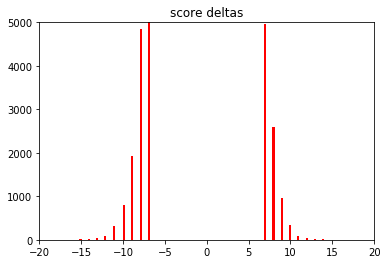

In [8]:
fig = plt.figure()
plt.ylim([0,5000])
plt.xlim([-20,20])
#plt.hist(test['delta1'],bins=20, label='team2')
#plt.hist(test['delta2'], bins=20, color='y', alpha= 0.5, label='team2')
plt.hist(runs['scorediffdelta'], bins=250, color='r', alpha=1, label='diff')
plt.title("score deltas")
plt.show()

In [9]:
print(teamdict)

{'AAMU': 'Alabama A&M', 'ACU': 'Abilene Christian', 'AFA': 'Air Force', 'AKR': 'Akron', 'ALA': 'Alabama', 'ALB': 'Albertus Magnus', 'ALBY': 'Albany', 'ALCN': 'Alcorn St', 'ALL': 'Alice Lloyd College', 'ALLEN': 'Allen', 'ALST': 'Alabama St', 'AMCC': 'Texas A&M-CC', 'AMER': 'American', 'AMI': 'Texas A&M-Int', 'APP': 'Appalachian St', 'AQU': 'Aquinas', 'ARIZ': 'Arizona', 'ARK': 'Arkansas', 'ARMY': 'Army', 'ARST': 'Arkansas St', 'ASU': 'Arizona St', 'AUB': 'Auburn', 'AUG': 'Augustana ILL', 'AUS': 'Austin', 'BALL': 'Ball St', 'BAPT': 'Central Baptist', 'BAY': 'Baylor', 'BBS': 'Barber Scotia', 'BC': 'Boston C', 'BCU': 'Bethune', 'BEL': 'Belmont', 'BGSU': 'Bowling Green', 'BING': 'Binghamton', 'BLU': 'Bluefield', 'BRAD': 'Bradley', 'BRWN': 'Brown', 'BRY': 'Bryant', 'BSU': 'Boise St', 'BU': 'Boston U', 'BUCK': 'Bucknell', 'BUFF': 'Buffalo', 'BUT': 'Butler', 'BYU': 'Brigham Young', 'CAL': 'California', 'CAM': 'Campbell', 'CAN': 'Canisius', 'CAR': 'Carroll (MT)', 'CCAR': 'Coastal Carolina', 'CCS

In [73]:
#output = [timeouts - list of callers, caller winning, runstop]

skips = 0
difflength = 3 # This value should extend a little to see if there was a timeout during the development of the run
extraevents = 3
results = []
for i,row in runs.iterrows():
    # continuous runs will show up as new rows in runs.
    # We want to consider each run it's own event, so we skip run events that were accounted for in previous loop
    for n in range(skips):
        continue
    skips = 0
    
    ind = data.loc[data.rowid == row['rowid']].index.values[0]
    runstarttime = row['time']
    working = data.iloc[ind-difflength-extraevents:ind+10] # take 3 extra events. Make sure this is matched 
    
    print(working)
    
    timeouts = []
    scorefuture = []
    for j,event in working.iterrows():
        
        if j == ind-difflength-extraevents:
            # Identify currently running team
            teamlist = [event['team1'].strip(),event['team2'].strip()]
            
        # If the slice range crosses a period skip it.
        if runstarttime > event['time'] and j < ind:
            continue
            
        if j == ind - difflength:     
            # if score difference > for team 1 return index 0. If team 2 scores more, return 1
            runnerindex = 0 if data.iloc[ind]['score1'] - event['score1'] > data.iloc[ind]['score2']-event['score2'] else 1
            runner = teamlist[runnerindex]
            
        print(event['event'].lower())
        print('timeout' in event['event'].lower())
        if 'timeout' in event['event'].lower():
            # Check if timeout caller is winning
            caller = determine_TO_caller(event['event'], teamlist, teamdict)
            is_winning = is_caller_winning(teamlist, [event["score1"],event["score2"]], caller)
            # Check if the TO caller is the team that is running (unlikely)
            is_running = caller == runner # TV == False
            timeouts.append([caller, is_winning, is_running])
            print(caller, is_winning, is_running)
            
        if j > ind:
            scorefuture.append([event['score1'],event['score2']])
            # Non-running team scored points (0-1 = -1 == 1 in two item list)
            if scorefuture[-2][runnerindex-1] < scorefuture[-1][runnerindex-1]:
                break
            else:
                skips += 1
        elif j == ind:
            scorefuture.append([event['score1'],event['score2']])
            
    winner = teamlist[0 if (final['score1'].values > final['score2'].values) else 1]
    results.append([timeouts, scorefuture, winner])
    if i > 100:
        break
        
for row in results:
    print(row)

    rowid     gameid                                    event team1 team2  \
42    150  253130183                 Foul on Terrence Roberts   COR   SYR   
43    155  253130183                     End of the 1st Half.   COR   SYR   
44    157  253130183    Louie McCroskey made Two Point Layup.   COR   SYR   
45    158  253130183      Andrew Naeve made Two Point Jumper.   COR   SYR   
46    162  253130183       Adam Gore made Three Point Jumper.   COR   SYR   
47    167  253130183                 Foul on Terrence Roberts   COR   SYR   
48    168  253130183        Ryan Rourke made Two Point Layup.   COR   SYR   
49    171  253130183   Demetris Nichols made Two Point Layup.   COR   SYR   
50    175  253130183                   Syracuse Full Timeout.   COR   SYR   
51    176  253130183    Gerry McNamara made Two Point Jumper.   COR   SYR   
52    182  253130183                     Official TV Timeout.   COR   SYR   
53    185  253130183                        Foul on Adam Gore   COR   SYR   